# Computer Vision
16/11/2021   
read images from video and analyse them.

In [1]:
%pylab inline
import pandas
import cv2
import os

Populating the interactive namespace from numpy and matplotlib


## convert video to frames

In [2]:
vidcap = cv2.VideoCapture('../../videos/Odor 1 .avi')
success,image = vidcap.read()
os.mkdir("../../videos/frames")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../../videos/frames'

In [7]:

count = 0
while success:
  cv2.imwrite("../../videos/frames/Odor1_frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

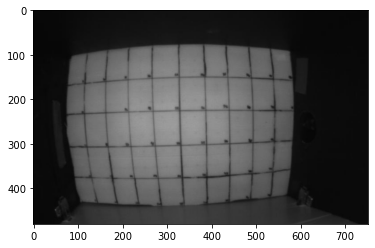

In [2]:
# importing matplotlib modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
imagename = '../../videos/frames/Odor1_frame1.jpg'
img = mpimg.imread(imagename)
  
# Output Images
plt.imshow(img)

In [8]:
img = cv2.imread('../../videos/frames/Odor1_frame1.jpg')
cv2.imshow('image', img) 

## very initial code
mainly taken from [here](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/)

In [3]:
# import the necessary packages
from imutils.video import VideoStream
import argparse
import datetime
import imutils
import time
import cv2

In [4]:

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-v", "--video", help="path to the video file")
# ap.add_argument("-a", "--min-area", type=int, default=500, help="minimum area size")
# args = vars(ap.parse_args())

# if the video argument is None, then we are reading from webcam
vs = cv2.VideoCapture('../../videos/Odor 1 .avi')
# initialize the first frame in the video stream
firstFrame = None

In [5]:
args = {}
args['min_area'] = 0.1

In [6]:
vs = cv2.VideoCapture('../../videos/Odor 1 .avi')
firstFrame = None
frame_num = 0
rat_rects = {}

# loop over the frames of the video
while True:
	# grab the current frame and initialize the occupied/unoccupied text
	frame = vs.read()[1]
	frame_num += 1
	# if the frame could not be grabbed, then we have reached the end of the video
	if frame is None:
		break
	# resize the frame, convert it to grayscale, and blur it
	frame = imutils.resize(frame, width=500)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	gray = cv2.GaussianBlur(gray, (21, 21), 0)
 
	# if the first frame is None, initialize it
	if firstFrame is None:
		firstFrame = gray
		continue

	# compute the absolute difference between the current frame and
	# first frame
	frameDelta = cv2.absdiff(firstFrame, gray)
	thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

	# dilate the thresholded image to fill in holes, then find contours on thresholded image
	thresh = cv2.dilate(thresh, None, iterations=2)
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
 
	# loop over the contours
	for c in cnts:
		# if the contour is too small, ignore it
		if cv2.contourArea(c) < args["min_area"]:
			continue
		# compute the bounding box for the contour
		(x, y, w, h) = cv2.boundingRect(c)
		rat_rects[frame_num] = {'x': x, 'y': y, 'w': w, 'h': h}
# cleanup the camera and close any open windows
vs.release()
cv2.destroyAllWindows()

<AxesSubplot:xlabel='x', ylabel='y'>

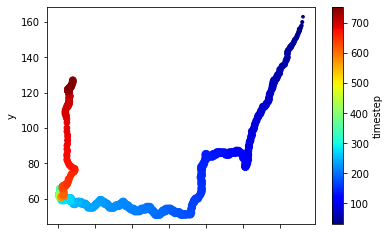

In [8]:
raw_data = pandas.DataFrame(rat_rects).T
raw_data.index.name = 'timestep'
raw_data.reset_index().plot.scatter(x='x', y='y', s='w', c='timestep', cmap='jet')

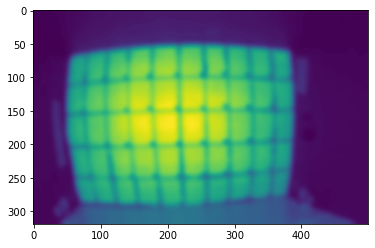

In [16]:
plt.imshow(firstFrame)

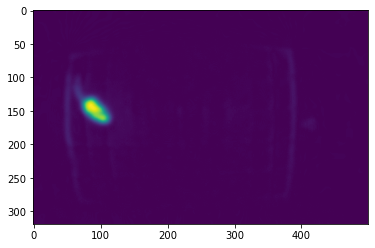

In [18]:
plt.imshow(frameDelta)